In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import time # For adding a small delay between requests
import requests
from urllib.parse import quote_plus # This is crucial for URL encoding
from urllib.parse import urlencode
import sqlite3

In [9]:
# Define the base API URL
base_url = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv"
params = {
    "$order": "crash_date DESC",
    "$limit": 50000
}

query_string = urlencode(params)
api_url_recent = f"{base_url}?{query_string}"

# Initialize an empty DataFrame
nyc_data_df_recent = pd.DataFrame()

In [12]:
try:
    print(f"Attempting to fetch the most recent {limit_records} records from: {api_url_recent}")
    # Use pandas to directly read the CSV from the constructed URL
    nyc_data_df_recent = pd.read_csv(api_url_recent)
    print("Data fetched and loaded into DataFrame successfully!")

    if nyc_data_df_recent.empty:
        print("API returned an empty dataset for the most recent records.")

except pd.errors.EmptyDataError:
    print(f"No data: The CSV file at {api_url_recent} is empty.")
except pd.errors.ParserError as e:
    print(f"Error parsing CSV data from {api_url_recent}: {e}")
except requests.exceptions.RequestException as e:
    print(f"Error fetching data (network issue or invalid URL) from {api_url_recent}: {e}")
except Exception as e:
    print(f"An unexpected error occurred while fetching from {api_url_recent}: {e}")

# Display summary of the most recent data
if not nyc_data_df_recent.empty:
    print(f"\nSuccessfully loaded {len(nyc_data_df_recent)} most recent records.")
    print("\nFirst 5 rows of the DataFrame (should be most recent):")
    print(nyc_data_df_recent.head())

    print("\nDataFrame Info for recent records:")
    nyc_data_df_recent.info()
    nyc_data_df_recent.describe()

    print("\nCheck the 'crash_date' and 'crash_time' of the first and last records:")
    if 'crash_date' in nyc_data_df_recent.columns and 'crash_time' in nyc_data_df_recent.columns:
        # Convert to datetime for proper sorting check if needed (depends on how pandas reads them)
        # For simplicity, just display as strings initially
        print(f"First record (most recent): Date={nyc_data_df_recent['crash_date'].iloc[0]}, Time={nyc_data_df_recent['crash_time'].iloc[0]}")
        print(f"Last record: Date={nyc_data_df_recent['crash_date'].iloc[-1]}, Time={nyc_data_df_recent['crash_time'].iloc[-1]}")
    else:
        print("Crash date/time columns not found in DataFrame.")

else:
    print("\nNo recent data loaded into DataFrame.")

Attempting to fetch the most recent 50000 records from: https://data.cityofnewyork.us/resource/h9gi-nx95.csv?%24order=crash_date+DESC&%24limit=50000
Data fetched and loaded into DataFrame successfully!

Successfully loaded 50000 most recent records.

First 5 rows of the DataFrame (should be most recent):
                crash_date crash_time   borough  zip_code   latitude  \
0  2025-05-27T00:00:00.000      20:04     BRONX   10461.0  40.845287   
1  2025-05-27T00:00:00.000      10:59  BROOKLYN   11210.0  40.628002   
2  2025-05-27T00:00:00.000      12:50    QUEENS   11375.0  40.720660   
3  2025-05-27T00:00:00.000      12:38       NaN       NaN  40.754898   
4  2025-05-27T00:00:00.000       0:00       NaN       NaN  40.753100   

   longitude                        location      on_street_name  \
0 -73.848630   \n,  \n(40.845287, -73.84863)       TOMLINSON AVE   
1 -73.944050   \n,  \n(40.628002, -73.94405)                 NaN   
2 -73.838980    \n,  \n(40.72066, -73.83898)             

NameError: name 'nyc_data_df' is not defined

In [14]:
# Step 3: Connect to SQLite and prepare the table
db_path = "nyc_crashes.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Optional: Limit column names to SQL-friendly versions
nyc_data_df_recent.columns = [col.lower().replace(" ", "_") for col in nyc_data_df_recent.columns]

# Step 4: Create table if it doesn't exist
# Infer SQLite-compatible schema from the DataFrame
nyc_data_df_recent.to_sql("crashes", conn, if_exists="replace", index=False)

print("Data inserted into 'crashes' table successfully.")

# Step 5: Verify table structure (optional)
cursor.execute("PRAGMA table_info(crashes)")
print("\nTable schema:")
for row in cursor.fetchall():
    print(row)

# Close connection
conn.close()

Data inserted into 'crashes' table successfully.

Table schema:
(0, 'crash_date', 'TEXT', 0, None, 0)
(1, 'crash_time', 'TEXT', 0, None, 0)
(2, 'borough', 'TEXT', 0, None, 0)
(3, 'zip_code', 'REAL', 0, None, 0)
(4, 'latitude', 'REAL', 0, None, 0)
(5, 'longitude', 'REAL', 0, None, 0)
(6, 'location', 'TEXT', 0, None, 0)
(7, 'on_street_name', 'TEXT', 0, None, 0)
(8, 'off_street_name', 'TEXT', 0, None, 0)
(9, 'cross_street_name', 'TEXT', 0, None, 0)
(10, 'number_of_persons_injured', 'INTEGER', 0, None, 0)
(11, 'number_of_persons_killed', 'INTEGER', 0, None, 0)
(12, 'number_of_pedestrians_injured', 'INTEGER', 0, None, 0)
(13, 'number_of_pedestrians_killed', 'INTEGER', 0, None, 0)
(14, 'number_of_cyclist_injured', 'INTEGER', 0, None, 0)
(15, 'number_of_cyclist_killed', 'INTEGER', 0, None, 0)
(16, 'number_of_motorist_injured', 'INTEGER', 0, None, 0)
(17, 'number_of_motorist_killed', 'INTEGER', 0, None, 0)
(18, 'contributing_factor_vehicle_1', 'TEXT', 0, None, 0)
(19, 'contributing_factor_vehi

In [30]:
injury_stats = nyc_data_df['number_of_persons_injured'].describe()
fatality_stats = nyc_data_df['number_of_persons_killed'].describe()
injury_stats, fatality_stats

(count    50000.000000
 mean         0.473000
 std          0.796243
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%          1.000000
 max         18.000000
 Name: number_of_persons_injured, dtype: float64,
 count    50000.000000
 mean         0.002840
 std          0.055785
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%          0.000000
 max          3.000000
 Name: number_of_persons_killed, dtype: float64)

In [31]:
# TODO: Calculate top vehicles for injuries
top_vehicles_injuries = nyc_data_df.groupby('vehicle_type_code1')['number_of_persons_injured'].sum().sort_values(ascending=False).head(10)
# TODO: Calculate top vehicles for deaths
top_vehicles_deaths = nyc_data_df.groupby('vehicle_type_code1')['number_of_persons_killed'].sum().sort_values(ascending=False).head(10)
top_vehicles_injuries, top_vehicles_deaths

(vehicle_type_code1
 Sedan                                  11034
 Station Wagon/Sport Utility Vehicle     8015
 Taxi                                     825
 Bike                                     634
 Pick-up Truck                            395
 E-Bike                                   379
 Bus                                      347
 Motorcycle                               313
 Box Truck                                226
 E-Scooter                                178
 Name: number_of_persons_injured, dtype: int64,
 vehicle_type_code1
 Sedan                                  49
 Station Wagon/Sport Utility Vehicle    37
 Motorcycle                             16
 Pick-up Truck                           8
 E-Bike                                  7
 Bus                                     4
 Motorscooter                            3
 Taxi                                    2
 Refrigerated Van                        2
 Tractor Truck Diesel                    2
 Name: number_of_perso

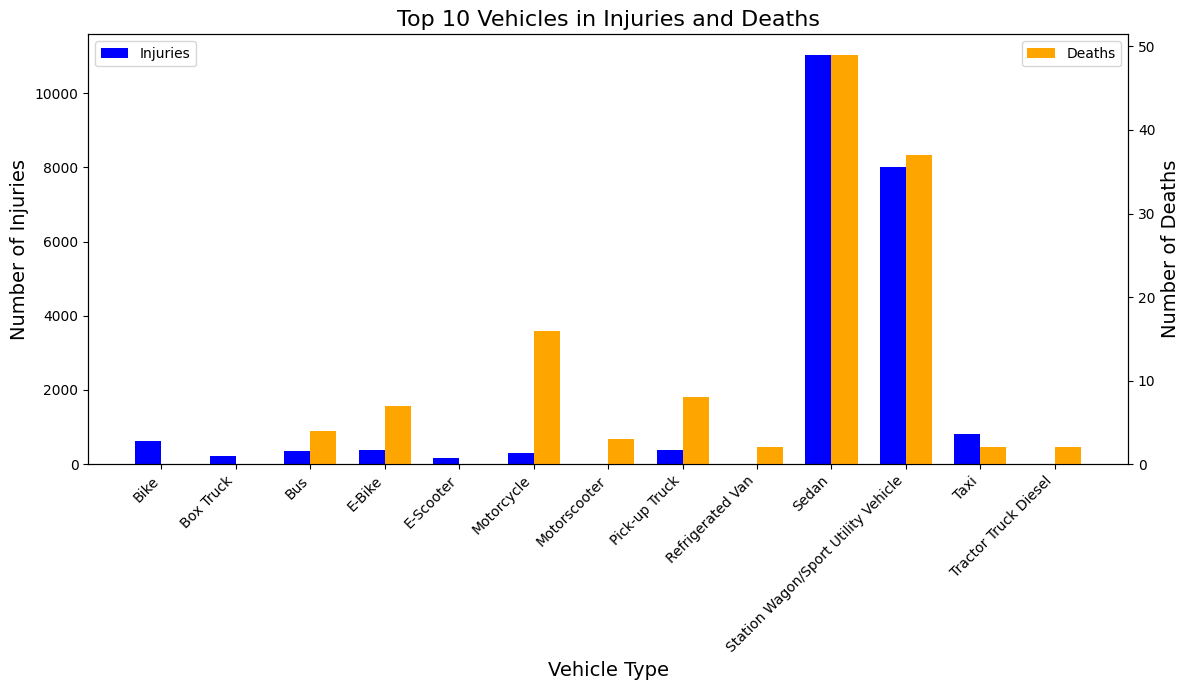

In [32]:

# TODO: Combine the data into a DataFrame
combined_data = pd.DataFrame({'Injuries': top_vehicles_injuries, 'Deaths': top_vehicles_deaths})

# Set the width of the bars
bar_width = 0.35

# Plotting the combined bar chart with bars next to each other
fig, ax1 = plt.subplots(figsize=(12, 7))

# Generate a list of indices for the x-axis
indices = np.arange(len(combined_data))

# Plotting the bars for injuries
ax1.bar(indices - bar_width/2, combined_data['Injuries'], bar_width, color='blue', label='Injuries')

# TODO: Create a secondary y-axis for deaths
ax2 = ax1.twinx()

# Plotting the bars for deaths next to injuries
ax2.bar(indices + bar_width/2, combined_data['Deaths'], bar_width, color='orange', label='Deaths')

# Adding labels and title
ax1.set_title('Top 10 Vehicles in Injuries and Deaths', fontsize=16)
ax1.set_xlabel('Vehicle Type', fontsize=14)
ax1.set_ylabel('Number of Injuries', fontsize=14)
# TODO: Set the label for the secondary y-axis
ax2.set_ylabel('Number of Deaths', fontsize=14)
ax1.set_xticks(indices)
ax1.set_xticklabels(combined_data.index, rotation=45, ha='right')

# Adding legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjusting layout and displaying the combined chart
plt.tight_layout()
plt.show()